__Cell 0:__

We import usual packages. 
Additionally, necessary external functions to calculate synthetic seismograms in an anisotropic setting are called.

(Note: further explanations are given in "functions_anisotropy.py")

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functions_anisotropy import *

## Estimating wave velocities

author: Sebastian Noe, snoe@geophysik.uni-muenchen.de

In this experiment, wave velocities are estimated for numerous propagation directions for anisotropic media.

#### Why is it possible to estimate velocities from single station data? 

There is no phase difference between rotation rate and acceleration. For each wavefield $m = qP, qS1$ or $qS2$, we observe following proportionalities

$
\ddot u_{x,m} = -A\omega^2n_{x,m}
$

$
\ddot u_{y,m} = -A\omega^2n_{y,m}
$

$
\ddot u_{z,m} = -A\omega^2n_{z,m}
$

$
\dot \Omega_{x,m} = -\frac{A\omega^2}{2v_m}(\nu\times n_m)_x = -\frac{A\omega^2}{2v_m}(\nu_yn_{z,m}-\nu_zn_{y,m})
$

$
\dot \Omega_{y,m} = -\frac{A\omega^2}{2v_m}(\nu\times n_m)_y = -\frac{A\omega^2}{2v_m}(\nu_zn_{x,m}-\nu_xn_{z,m})
$

$
\dot \Omega_{z,m} = -\frac{A\omega^2}{2v_m}(\nu\times n_m)_z = -\frac{A\omega^2}{2v_m}(\nu_xn_{y,m}-\nu_yn_{x,m})
$

The seismometer could be rotated, such that in the new reference frame the direction of propagation is parallel to the x-axis $\nu=(1,0,0)^T$. Additionally, the plane perpendicular to $\nu$ can be rotated such that the shear waves are split.
Thus, rotations are:

$
\dot\Omega_{x,m} = 0
$

$
\dot\Omega_{y,m} = \frac{A\omega^2}{2v_m}n_{z,m}
$

$
\dot\Omega_{z,m} = -\frac{A\omega^2}{2v_m}n_{y,m}
$

Extract velocities by forming ratios:

$
\frac{\ddot u_{y,m}}{\dot\Omega_{z,m}} = 2v_m
$

$
\frac{\ddot u_{z,m}}{\dot\Omega_{y,m}} = 2v_m
$

$
\frac{\sqrt{\ddot u_{y,m}^2+\ddot u_{z,m}^2}}{\sqrt{\dot\Omega_{y,m}^2+\dot\Omega_{z,m}^2}} = 2v_m
$

The first two equations will yield quasi-shear wave velocities. Their amplitudes are simply the maximum values over the entire time interval. For the last equation, one has to determine the amplitudes corresponding to the first arrival. The resulting velocity will be qP and it is only possible to determine if curls are observed.


#### The function

The main function is defined in cell 1. It can roughly be split into three parts, 1) Rotation such that $x=\nu$ 2) Rotation such that y and z exhibit profound shear wave splitting and 3) the picking of amplitudes for the qS estimation.

The most important inputs are the original (unrotated) measurements of all 6 components and the direction of propagation $\nu$. This direction may already be a previously estimated vector. The time array is passed along for potential plots.



##### 1) Rotation of seisometer such that x-axis points into the direction of propagation

First, the direction of propagation is written down in terms of horizontal and vertical angles ($\phi,\theta$).
The rotation is necessary for the estimation because it is done with amplitude ratios between translational and rotational signals. Because rotation entirely takes place in the plane vertical to the propagation direction, the amplitudes of the rotation are too small when the axis doesn't lie perfectly in the plane. To perform this specific transformation of the signal we need a rotation matrix.

The Rodrigues' rotation formula is used to calculate the rotation matrix. It describes a rotation around a vector $r$ by some angle $\alpha$. The idea is to find vector $r$ such the x-axis is rotated by angle $\alpha=\pi$ and falls perfectly onto $\nu$. Therefore, $r$ must be halfway between $x$ and $\nu$. 

$
r = \frac{1}{2}\begin{pmatrix}1\\0\\0\end{pmatrix}+\frac{1}{2}\begin{pmatrix}\cos(\phi)\sin(\theta)\\\sin(\phi)\sin(\theta)\\\cos(\theta)\end{pmatrix}
$

Afterwards, $r$ is normalized. Rodrigues' rotation formula to get a rotation matrix is (for $\alpha=\pi$):

$
R = I + \sin(\alpha)K+(1-\cos(\alpha))K^2 = I + 2K^2
$
(https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula)

where K is the cross-product matrix with the identity:

$
Kv = r\times v
$

so

$
K = \begin{pmatrix} 0&-r_z & r_y \\ r_z&  0 & -r_x \\ -r_y & r_x & 0       \end{pmatrix}
$
.

It can be checked whether the rotation worked by looking at the plots (turn on by setting _plot_rotated_seismo=True_). The rotation rate around the x-axis should constantly be zero because it points in the direction of propagation and $\dot\Omega\perp\nu$. 

##### 2) Rotation around x-axis such that y and z each show shear wave splitting perfectly

This section is mostly from Heiner's notebook. The maximum cross-correlation coefficient between y and z axis is searched for by rotating around the x-axis. The angle with the maximum ccc will be the final rotation of the seismometer. This method captures shear wave splitting because the ccc will be the highest when the respective amplitudes on both components are maximized.  

##### 3) Picking amplitudes

Having correctly rotated seismograms, the shear wave velocities can be estimated by

$
V_{S1} = -\frac{1}{2}\ddot u_y/\dot\Omega_z
$

$
V_{S2} = -\frac{1}{2}\ddot u_z/\dot\Omega_y
$

where the values of the rotation rates and accelerations are the maximum values.

For the estimation of the qP-velocity an extra step has to be introduced. Whenever the translational data exceeds some threshold for the first time, the corresponding amplitudes of translational and rotational components are extracted. If rotational motions are zero, the velocity cannot be estimated.

$
V_{P} = \frac{1}{2}\sqrt{\ddot u_{y}^2+\ddot u_{z}^2}/\sqrt{\dot\Omega_{y}^2+\dot\Omega_{z}^2}
$


The function returns three estimated velocities, the rotated seismograms and the rotation matrix.


__Cell 1:__

In [2]:
def estimate_velocity(seis, nu,t):
    nt = len(seis[0,:])
    r2d = 180/np.pi
    vel_e = np.zeros(2)
    
    theta, phi = get_angles(nu)
    
    R = np.zeros((3,3))
    
    # Rodrigues' rotation formula, matrix will be rotated around vector r by angle pi 
    # x-axis=direction of propagation after rotation

    
    r = [(1. + np.cos(phi)*np.sin(theta))/2,\
         (np.sin(phi)*np.sin(theta))/2,\
         np.cos(theta)/2]
    r_sum = 0
    for i in range(0,3):
        r_sum += r[i]**2
    for i in range(0,3):
        r[i] = r[i]/np.sqrt(r_sum)
        
    K_sq = [[-r[1]**2-r[2]**2,r[0]*r[1],r[0]*r[2]], \
            [r[0]*r[1],-r[0]**2-r[2]**2,r[1]*r[2]], \
            [r[0]*r[2],r[1]*r[2],-r[0]**2-r[1]**2]]
    
    R[0,0] = 1 + 2*K_sq[0][0]
    R[1,0] = 2*K_sq[1][0]
    R[2,0] = 2*K_sq[2][0]

    R[0,1] = 2*K_sq[0][1]
    R[1,1] = 1 + 2*K_sq[1][1]
    R[2,1] = 2*K_sq[2][1]

    R[0,2] = 2*K_sq[0][2]
    R[1,2] = 2*K_sq[1][2]
    R[2,2] = 1 + 2*K_sq[2][2]
    
    seis_new = np.zeros((6,nt))
    
    for k in range(0,3):
        seis_new[k,:]   = R[k,0]*seis[0,:]+R[k,1]*seis[1,:]+R[k,2]*seis[2,:]
        seis_new[k+3,:] = R[k,0]*seis[3,:]+R[k,1]*seis[4,:]+R[k,2]*seis[5,:]
    
    
    nang = 721
    xc  = np.zeros(nang)
    ang = np.linspace(0,180,nang)
    d2r = r2d**-1

    for i in range(nang):
        angle = ang[i]
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
        junk = np.corrcoef(xr, yr)
        xc[i] = junk[1,0]
        ang[i] = angle
        
    imax = np.argmax(xc)
    imax2 = np.argmin(xc)
    if abs(imax)<abs(imax2):
        imax = imax2
    amax = ang[imax]
    
    angle = amax
    xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
    yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]
    
    seis_new[1,:] = xr
    seis_new[2,:] = yr
    
    xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
    yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]
    
    seis_new[4,:] = xrr
    seis_new[5,:] = yrr
    
    R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
    R = np.dot(R,R2.transpose())
        
    j1 = np.argmax(xrr)
    j1c = np.argmin(xrr)
    j2 = np.argmax(yrr)
    j2c = np.argmin(yrr)
    qS1 = abs(yr[j1]/xrr[j1])/2
    qS2 = abs(xr[j2]/yrr[j2])/2
    
    safety = nt//100
    if abs(j1-j2)<safety or abs(j1-j2c)<safety or abs(j1c-j2)<safety:    # if picks are from same peak!
        angle = 45.
        xr = np.cos(angle*d2r)*seis_new[1,:] -  np.sin(angle*d2r)*seis_new[2,:]
        yr = np.sin(angle*d2r)*seis_new[1,:] +  np.cos(angle*d2r)*seis_new[2,:]

        seis_new[1,:] = xr
        seis_new[2,:] = yr

        xrr = np.cos(angle*d2r)*seis_new[4,:] -  np.sin(angle*d2r)*seis_new[5,:]
        yrr = np.sin(angle*d2r)*seis_new[4,:] +  np.cos(angle*d2r)*seis_new[5,:]

        seis_new[4,:] = xrr
        seis_new[5,:] = yrr

        R2 = np.array([[1,0,0],[0,np.cos(angle*d2r),-np.sin(angle*d2r)],[0,np.sin(angle*d2r),np.cos(angle*d2r)]])
        R = np.dot(R,R2.transpose())
        
        j1 = np.argmax(xrr)
        j2 = np.argmax(yrr)
        qS1 = abs(yr[j1]/xrr[j1])/2
        qS2 = abs(xr[j2]/yrr[j2])/2
    

    ip = np.argmax(seis_new[0,:])
    uy = seis_new[1,ip]
    uz = seis_new[2,ip]
    ry = seis_new[4,ip]
    rz = seis_new[5,ip]
    
    qP = .5 * np.sqrt(uy**2+uz**2)/np.sqrt(ry**2+rz**2)
        
    if qS1<qS2:
        qS1, qS2 = qS2, qS1
    
    vel_e = [qP, qS1, qS2]
    
    return vel_e, seis_new, R

__Cell 2:__

Get a list of available anisotropic media. 

VTI media from Thomsen (1986).

In [3]:
medium = load_medium_list()

#0 isotropic
#1 taylor sandstone
#2 mesaverde clayshale
#3 mesaverde laminated siltstone
#4 mesaverde mudshale
#5 mesaverde calcareous sandstone
#6 quartz


__Cell 3:__

Here, we load an elastic tensor. You can change the index to try out different anisotropic media.
It's possible to display all six values (vertical p-wave velocity, vertical shear wave velocity, $\epsilon$,$\delta$,$\gamma$ and density). 
If you want to change specific parameters, you must add the line _parameter = new_parameter_ inside the function, e.g. _eps=new_eps_, where only new parameters are changed while all unspecified values remain the same. 

In [4]:
index = 1

C, density = get_specific_VTI(medium[index], give_thomsen=True)
#C, density = get_random_C('triclinic',20)

taylor sandstone
 
vp0     = 3368
vs0     = 1829
eps     = 0.11
delta   = -0.035
gamma   = 0.255
density = 2500
 
[[34.5974432   9.34087365 10.61386654  0.          0.          0.        ]
 [ 9.34087365 34.5974432  10.61386654  0.          0.          0.        ]
 [10.61386654 10.61386654 28.35856     0.          0.          0.        ]
 [ 0.          0.          0.          8.3631025   0.          0.        ]
 [ 0.          0.          0.          0.          8.3631025   0.        ]
 [ 0.          0.          0.          0.          0.         12.62828478]]


__Cell 4:__

In this experiment you can choose any direction of propagation you want for the velocity estimation. After execution, the prompt asks for three values (x,y and z) that define the direction of propagation. The given vector doesn't have to be of unit length. Further, you can easily change the frequency. If you want to try other elastic tensors, go back to Cell 3.

First, the synthetic seismograms will be calculated. 
The accurate shear wave velocities are stored in _vel_. Afterwards, the estimations for the wave velocities will be computed with the function defined above.
You have the option of adding plots of original and rotated measurements.

The error between estimated and actual velocities is calculated. It's order of magnitude (base 10) is part of the results.


x 1
y 0
z 1
Originial data


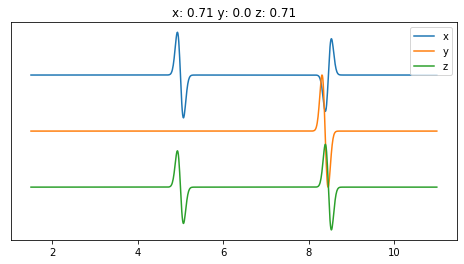

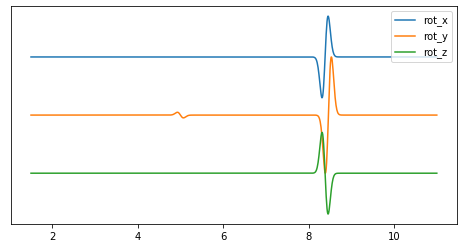

Rotated data


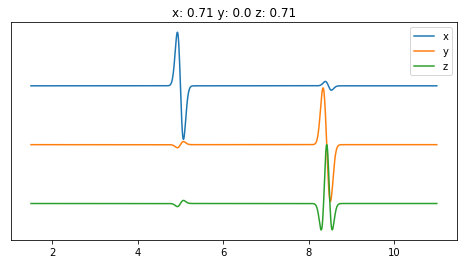

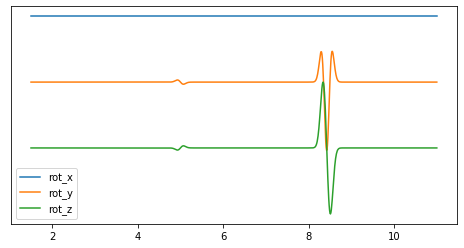

Estimated velocities: 
3437.2300391812078 2040.8671641606418 2023.6208627545661
Actual velocities: 
3437.2300391812096 2048.9698521452187 2030.2441473257193
Relative error (order of magnitude)
-15.26
-2.4
-2.49


In [5]:
f = 10.
fs = 100.
plot_original_seismo = True
plot_rotated_seismo = True

nus,gammas = get_direction('input', C,1 )
vel,v = get_eigenvals(gammas[0], density)
seis, t = get_seis(v, vel, nus[0], f,fs)

vel_s = extract_slower_velocities(vel)
if plot_original_seismo:
    print('Originial data')
    plotseis(seis,t,nus[0])
nu_e = get_propagation_direction(seis)
vel_e, seis_rot , _ = estimate_velocity(seis, nu_e,t)
if plot_rotated_seismo:
    print('Rotated data')
    plotseis(seis_rot,t,nus[0])

print('Estimated velocities: ')
print(vel_e[0],vel_e[1],vel_e[2])
print('Actual velocities: ')
print(max(vel),vel_s[0],vel_s[1])
print('Relative error (order of magnitude)')
e0 = abs(vel_e[0]/max(vel)-1)
e1 = abs(vel_e[1]/vel_s[0]-1)
e2 = abs(vel_e[2]/vel_s[1]-1)
if e0!=0.0:
    print(round(np.log10(e0),2))
else:
    print('machine precision')
if e1!=0.0:
    print(round(np.log10(e1),2))
else:
    print('machine precision')
if e2!=0.0:
    print(round(np.log10(e2),2))
else:
    print('machine precision')

__Cell 5:__

This cell gives the option to repeat the experiment N-times for either randomly generated directions of propagation or directions following a plane. The plane is defined with two angles. $\phi_e$ is the horizontal angle where the plane of directions pierces the horizontal plane and $theta_e$ is the minimum vertical angle.
At the end, the experiment will also give a percentage of success for the estimation such that they are within $\epsilon=0.1$% of the correct values. Inside the first for-loop, synthetic seismograms for all directions are computed. The second for-loop evaluates estimated velocities against actual velocities.

Just like in Cell 4, numerous plots may be added by setting respective boolean variables to True before execution. The error of each estimation is given in orders of magnitude (base 10).

Note: For VTI, it's not possible to estimate qP-velocity for waves travelling purely horizontal or purely vertical as the P-curl is zero.

C:\Users\sebi\Downloads\Master-notebooks\functions_anisotropy.py:480: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(111, projection='stereonet')


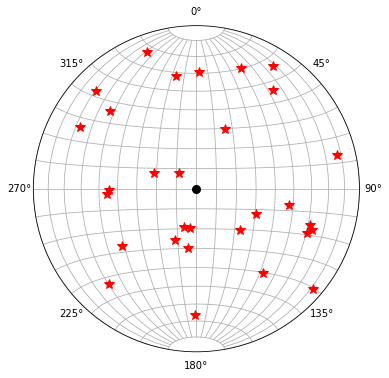

#1
Estimated velocities: 
3360.553339001274 1921.6870650665091 1902.6293096371019
Actual velocities: 
3360.553339001743 1922.2126333487515 1884.1524430113782
Relative error (order of magnitude)
-12.85
-3.56
-2.01
 
#2
Estimated velocities: 
3360.581978282122 1918.3391544449685 1899.8928329319879
Actual velocities: 
3360.5819782816325 1918.898703185519 1881.876665377026
Relative error (order of magnitude)
-12.84
-3.54
-2.02
 
#3
Estimated velocities: 
3615.941625251565 2185.8322858293554 1925.9269418607928
Actual velocities: 
3615.941625251562 2185.8322858293554 1925.9269418607926
Relative error (order of magnitude)
-15.18
machine precision
-15.65
 
#4
Estimated velocities: 
3610.880834914598 2182.6483493359783 1930.135414919173
Actual velocities: 
3610.880834914608 2182.6483493359783 1930.1354149191732
Relative error (order of magnitude)
-14.56
machine precision
-15.95
 
#5
Estimated velocities: 
3368.962946515109 1989.6953304842555 1963.7952295871867
Actual velocities: 
3368.962946515

In [6]:
N = 30
f = 10.
fs = 100.

plot_original_seismo = False

all_vel = []
all_seis = []
all_t = []
success = 0
eps = 0.01

nus,gammas = get_direction('random', C,N,phi_e=60.,theta_e=0.)
#modes 'random', 'planar'

plot_directions(nus)

for i in range(0,N):
    vel,v = get_eigenvals(gammas[i], density)
    seis, t = get_seis(v, vel, nus[i], f,fs)
    
    vel_s = extract_slower_velocities(vel)
    all_vel.append([max(vel),vel_s[0],vel_s[1]])
    all_seis.append(seis) 
    all_t.append(t)
    
for i in range(0,N):
    if plot_original_seismo:
        plotseis(all_seis[i],all_t[i],nus[i])
    
    nu_e = get_propagation_direction(all_seis[i])
    vel_e, _ , _ = estimate_velocity(all_seis[i], nu_e,all_t[i])
                                        
    print('#'+str(i+1))
    print('Estimated velocities: ')
    print(vel_e[0],vel_e[1],vel_e[2])
    print('Actual velocities: ')
    print(all_vel[i][0],all_vel[i][1],all_vel[i][2])
    print('Relative error (order of magnitude)')
    e0 = abs(vel_e[0]/all_vel[i][0]-1)
    e1 = abs(vel_e[1]/all_vel[i][1]-1)
    e2 = abs(vel_e[2]/all_vel[i][2]-1)
    if e0!=0.0:
        print(round(np.log10(e0),2))
    else:
        print('machine precision')
    if e1!=0.0:
        print(round(np.log10(e1),2))
    else:
        print('machine precision')
    if e2!=0.0:
        print(round(np.log10(e2),2))
    else:
        print('machine precision')
    print(' ') 
    
    if e0<eps and e1<eps and e2<eps:
        success+=1

print('Velocity estimation Success rate:')        
print(str(round(success/N*100,2))+'%')        
           
    